# Meshing eHydro Data

In [1]:
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
from pathlib import Path

import geopandas as gpd
import geomesher as gm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

In this example, we want to work with a messy geodataframe from [eHydro](https://www.sam.usace.army.mil/Missions/Spatial-Data-Branch/eHYDRO/). This dataset provides topobathymetry data for some limited locations across US. Our main objective is to convert the data into a mesh with unstructured grid and remap the topobathymetry data from the source GeoDataFrame to the mesh.

EHydro provides the data as a GeoPackage within a zip file. First, we use GeoPandas to read and plot the topoybathy data.

In [3]:
url = "https://ehydrotest.blob.core.usgovcloudapi.net/ehydro-surveys/CEMVN/SW_04_SWP_20230914_CS.ZIP"
topo = gpd.read_file(f"zip+{url}!{Path(url).stem}.gdb")

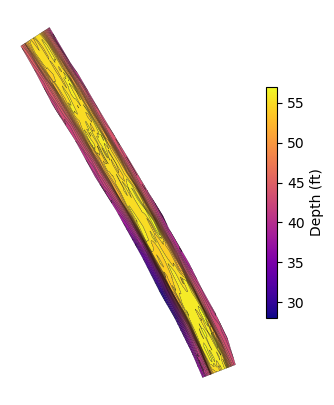

In [4]:
vmin, vmax = topo.depthMean.min(), topo.depthMean.max()
plot_kwds = {"edgecolor":"k", "linewidth": 0.15, "vmin": vmin, "vmax": vmax, "cmap": "plasma"}
ax = topo.plot(column="depthMean", figsize=(5, 5), legend=True, legend_kwds={"label": "Depth (ft)", "shrink": 0.6}, **plot_kwds)
ax.set_axis_off()

As is evident from the plot, the geometries in the data are highly irregular and contain self-intersecting polygons and multi-polygons. GeoMesher takes care of multi-polygons by first attempting to convert them into polygons and if it fails then it explodes the multi-polygons to its constituent polygons. However, even with these treatments, Gmsh fails to create a mesh. The best way to deal with these types of issues is performing three operations before passing them to GeoMesher: (1) Get the convex hull of all polygons, (2) unify all the resulting polygons into a single multi-polygon, (3) simplifying the resulting multi-polygon into a single polygon with a sensible tolerance. We use GeoPandas to perform these operations and then pass the resulting data to GeoMesher.

First, we compare two meshing algorithms (``AUTOMATIC`` and ``MESH_ADAPT``) with a small simplifying tolerance, then, we study the impact of tolerance on the meshing results.

In [5]:
geoms = [topo.convex_hull.unary_union.simplify(0.5)]
poly = gpd.GeoDataFrame(geometry=geoms, crs=topo.crs)
poly["cellsize"] = 300.0

mesher = gm.Mesher(poly)
mesh_auto = mesher.generate()
mesh_auto = gm.area_interpolate(topo, mesh_auto, intensive_variables=["depthMean"])
mesher.mesh_algorithm = "MESH_ADAPT"
mesh_adapt = mesher.generate()
mesh_adapt = gm.area_interpolate(topo, mesh_adapt, intensive_variables=["depthMean"])

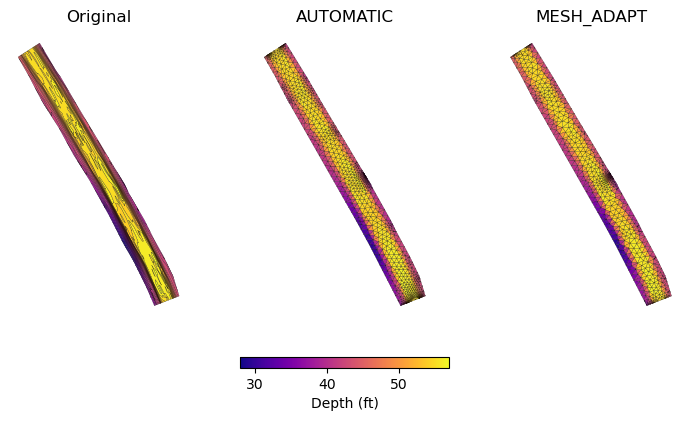

In [6]:
fig, axs = plt.subplots(ncols=3, figsize=(9, 5), dpi=100)
topo.plot(ax=axs[0], column="depthMean", **plot_kwds)
axs[0].set_title("Original")
mesh_auto.plot(ax=axs[1], column="depthMean", **plot_kwds)
axs[1].set_title("AUTOMATIC")
mesh_adapt.plot(ax=axs[2], column="depthMean", **plot_kwds)
axs[2].set_title("MESH_ADAPT")
_ = [ax.set_axis_off() for ax in axs]

norm = Normalize(vmin=plot_kwds["vmin"], vmax=plot_kwds["vmax"])
cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=plot_kwds["cmap"]), orientation='horizontal', ax=axs, pad=0.1, shrink=0.3, label="Depth (ft)")

We can see that ``MESH_ADAPT`` generates meshes with a more consistent area distribution. Next, we study the impact of tolerance on the meshing results using the ``MESH_ADAPT`` algorithm.

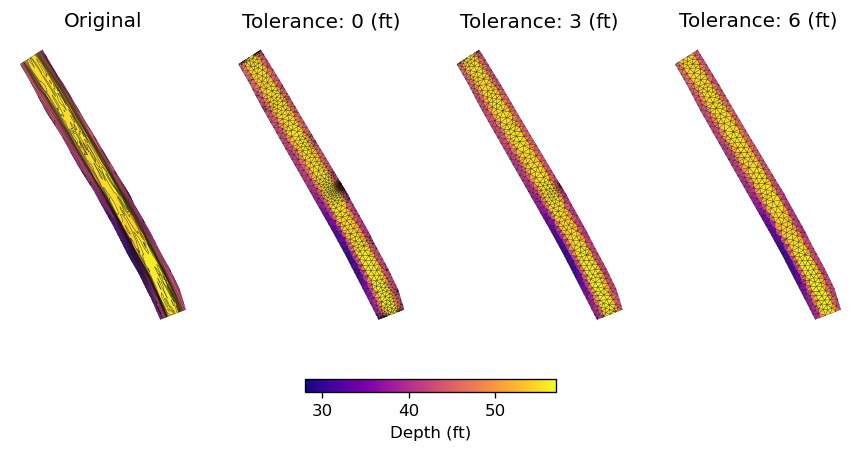

In [7]:
tol = list(range(0, 8, 3))
ncols = 3
nrows = (len(tol) + 1) // ncols
fig, axs = plt.subplots(ncols=len(tol) + 1, figsize=(9, 5), dpi=120)
topo.plot(ax=axs[0], column="depthMean", **plot_kwds)
axs[0].set_title("Original")
axs[0].set_axis_off()
for i, t in enumerate(tol, start=1):
    geoms = [topo.convex_hull.unary_union.simplify(t)]
    poly = gpd.GeoDataFrame(geometry=geoms, crs=topo.crs)
    poly["cellsize"] = 300.0
    mesh = gm.gdf_mesher(poly, meshing_algorithm="MESH_ADAPT")
    mesh = gm.area_interpolate(topo, mesh, intensive_variables=["depthMean"])
    if i == len(tol):
        mesh.plot(ax=axs[i], column="depthMean", **plot_kwds)
    else:
        mesh.plot(ax=axs[i], column="depthMean", **plot_kwds)
    axs[i].set_title(f"Tolerance: {t} (ft)")
    axs[i].set_axis_off()

norm = Normalize(vmin=plot_kwds["vmin"], vmax=plot_kwds["vmax"])
cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=plot_kwds["cmap"]), orientation='horizontal', ax=axs, pad=0.1, shrink=0.3, label="Depth (ft)")

As the plot shows, a tolerance value of close to 6 ft generates a mesh with a good balance between the number of elements and relatively uniform element size.